# KNN for classification

For this model, we shall be implementing a K nearest neighbour classifier for heart disease.KNN is a distance based (typically Euclidean) supervised learning algorithm. It chooses the  k closest neighbours and based on these neighbours, it assigns the majority class. We are also able to get a probability score of how likely the class label is based on the k closest neighbours.

 The sklearn library has a built in KNeighboursClassifier function which we will be utilising.

We first must download the necesary libraries/packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Obtaining our training dataset

Below we load the imputed data from the shared google drive and display the first 5 rows, to check everything is as expected. We load the imputed dataset (approx 36,000 datapoints).

In [2]:
url='https://drive.google.com/file/d/1S7em_UuD7yOiN4JMq__mlNDfcwV6NCYU/view'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
hd_data = pd.read_csv(url)
hd_data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.125,0.2,0.0,0.257703,0.3,0.000,0.2,0.125,0.125,...,0.0,0.2,0.6,0.887755,0.89,0.2,1.0,0.923077,0.500,0.78
1,1.0,0.125,0.3,0.0,0.266507,0.3,0.125,0.4,1.000,1.000,...,0.0,0.3,0.4,0.887755,0.89,0.2,1.0,0.923077,0.500,0.78
2,1.0,0.125,0.2,0.0,0.304322,0.2,0.125,0.2,0.125,0.000,...,0.0,0.3,0.6,0.295918,0.31,0.2,1.0,0.615385,0.500,0.02
3,1.0,0.125,0.2,0.0,0.266507,0.2,0.125,0.4,0.125,0.000,...,0.0,0.8,0.4,0.887755,0.89,0.3,0.0,0.923077,0.250,0.05
4,1.0,0.000,0.2,1.0,0.306923,0.2,0.125,0.4,0.125,0.125,...,0.0,0.3,0.4,0.887755,0.78,0.3,0.0,0.846154,0.125,0.04


We are interested in the balance of the data, as this can impact decisions on cross validation, sampling, performance metric etc. Below we plot a simple bar chart to illustrate class balance of heart disease patients vs non-heart disease patients in our training dataset.

In [4]:
print('Class Ratio:',sum(hd_data['HeartDiseaseorAttack'])/len(hd_data['HeartDiseaseorAttack']))
#8.8% of our data is heart disease

Class Ratio: 0.0883018465422094


## 2. Downsampling

I will propose 2 models for comparison, they will differ by their class proportions after downsampling. The code took too long to run on the full dataset, so by downsampling, we can improve our runtime.


### 2.1 Model with equal class ratio

Here we downsample only the patients who do not have heart disease. For this model, we do not wish to downsample the minority class (positive for heart disease) as we want this model to be very good at detecting heart disease, i.e., low number of false negatives. We are less bothered by false positives as the purpose of our model is to inform heart disease screening, rather than diagnosising.

Risks associated - overtraining to our data, won't generalise well.

In [5]:
heart_disease = hd_data[hd_data["HeartDiseaseorAttack"] == 1]
no_hd = hd_data[hd_data["HeartDiseaseorAttack"] == 0]

print(heart_disease.shape)
print(no_hd.shape)

(34770, 22)
(358993, 22)


In [6]:
from sklearn.utils import resample
no_hd_downsample1 = resample(no_hd,
             replace=True,
             n_samples=len(heart_disease),
             random_state=42)

print(no_hd_downsample1.shape)

(34770, 22)


<AxesSubplot:ylabel='Heart Disease or No Heart Disease'>

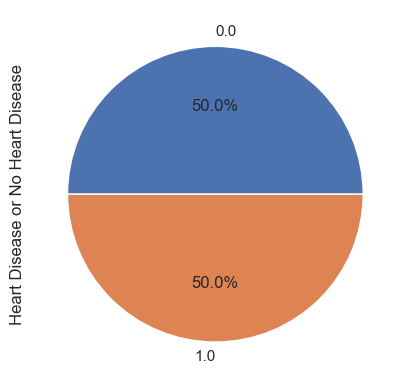

In [7]:
data_downsampled = pd.concat([no_hd_downsample1, heart_disease])

data_downsampled.groupby('HeartDiseaseorAttack').size().plot(kind='pie',
                                       y = "HeartDiseaseorAttack",
                                       label = "Heart Disease or No Heart Disease",
                                       autopct='%1.1f%%')

In [8]:
x = data_downsampled.drop('HeartDiseaseorAttack',axis=1)
y = data_downsampled['HeartDiseaseorAttack']

### 2.2 Model with stratified ratio

Here we downsample both classes. For this model, we want to preserve the class ratios. This allows us to compare how well the model generalises if we downsample the majority class. I am sure we will see interesting results between the two models, depending on the performance metric chosen at the testing stage.

Risks associated - model might not be as good at predicting the minority class.

In [9]:
ratio = sum(hd_data['HeartDiseaseorAttack'])/len(hd_data['HeartDiseaseorAttack'])

amount_hd = round(ratio*68000)

amount_no_hd = 68000 - amount_hd

print(amount_hd)
print(amount_no_hd)

6005
61995


In [10]:
from sklearn.utils import resample
no_hd_downsample2 = resample(no_hd,
             replace=True,
             n_samples=amount_no_hd,
             random_state=42)

from sklearn.utils import resample
hd_downsample2 = resample(heart_disease,
             replace=True,
             n_samples=amount_hd,
             random_state=42)

print(no_hd_downsample2.shape)
print(hd_downsample2.shape)

(61995, 22)
(6005, 22)


<AxesSubplot:ylabel='Heart Disease or No Heart Disease'>

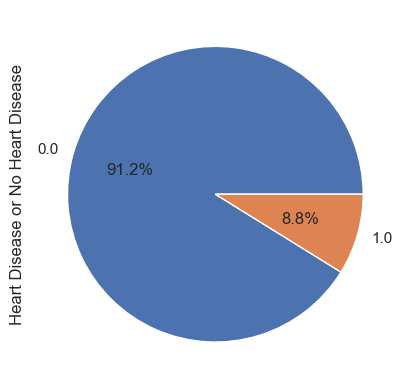

In [11]:
data_downsampled2 = pd.concat([no_hd_downsample2,hd_downsample2])

data_downsampled2.groupby('HeartDiseaseorAttack').size().plot(kind='pie',
                                       y = "HeartDiseaseorAttack",
                                       label = "Heart Disease or No Heart Disease",
                                       autopct='%1.1f%%')

In [12]:
x_down = data_downsampled2.drop('HeartDiseaseorAttack',axis=1)
y_down = data_downsampled2['HeartDiseaseorAttack']

## 3. KNN Search Algorithms Comparison

I am going to investigate the effect of different search algorithms for KNN and compare their runtime. Rather than running on the whole dataset (approx. 56K data points after downsampling for both models), I will see how long it takes to run on 3000 data points. I will however fit the models to the entire dataset. This means that for each data point in the set of 3000, it will look for the K nearest neighbour in all 56,000 points.

### 3.1 Brute force search

Such distance based algorithms are affected by the scale and range of variables. The KNN algorithm is biased towards variables with smaller magnitudes, so this must be mitigated through normalisation of the features values. 
However, our KNN shall be calculating the distances using the Mahalnobis distance, which automatically normalises the dataset, so we do not need to worry about normalisation beforehand.

Furthermore, the mahalanobis distance metric considers correlation between features. For instance, if Fruits and Veggies are highly correlated variables, it will reduce the combined weighting of them in the distance metric.

To ensure a fair test of the search algorithms, I shall be randomly sampling a smaller dataset (300 data points) from the already downsampled (preserved ratio) dataset. You could think of this set as the validation data for model selection. I shall reserve the original ratios in the dataset (6.9% heart disease).

In [13]:
amount_hd2 = round(ratio*300)

amount_no_hd2 = 300 - amount_hd2

print(amount_hd2)
print(amount_no_hd2)

from sklearn.utils import resample
no_hd_valid = resample(no_hd,
             replace=True,
             n_samples=amount_no_hd2,
             random_state=42)

from sklearn.utils import resample
hd_valid = resample(heart_disease,
             replace=True,
             n_samples=amount_hd2,
             random_state=42)


26
274


In [14]:
validation = pd.concat([no_hd_valid,hd_valid])

In [15]:
x1 = validation.drop('HeartDiseaseorAttack',axis=1)
y1 = validation['HeartDiseaseorAttack']

In [16]:
#Manually get covariance matrix of features, as this is a parameter necessary for the Mahlanobis metric

def get_covariance_matrix(hd_data, ddof=0):
    n_samples = hd_data.shape[0]
    C = np.dot(hd_data.T, hd_data) / (n_samples - ddof)
    return C

C=get_covariance_matrix(hd_data)

print(C.shape)

(22, 22)


Here we load more packages required for our KNN classifier.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import DistanceMetric


cov_matrix = C

knn = KNeighborsClassifier(metric='mahalanobis', algorithm='brute', metric_params={'VI': np.linalg.inv(cov_matrix)}) 


I am mainly interested in the varying runtimes at this point in the investigation, so I shall fit the models to the dataset which was downsampled with the preserved ratios (dataset 2). This assumes that brute force, KD Tree and Ball Tree algorithms all have similar levels of accuracy.

In [18]:
knn.fit(x_down,y_down)

KNeighborsClassifier(algorithm='brute', metric='mahalanobis',
                     metric_params={'VI': array([[ 1.40903141e+01, -3.09220165e+00,  1.04660506e+00,
         4.05841176e-01, -6.18027209e-01,  5.49200263e-01,
         5.90664183e+00,  2.95314874e+00, -4.10380451e-02,
         6.96688350e-02, -2.52573316e-02,  3.04270816e-01,
         5.38721498e-01, -1.68218811e+00, -6.51166807e+00,
         4.85607385e-02,  2.63617430e-01,  1...
       [ 1.03159624e-01, -8.12112896e-01, -4.16172476e-01,
        -1.10871723e+00,  4.77029104e+00, -2.23294774e+00,
        -6.81434569e-01, -2.02187273e-01,  6.18679199e-01,
        -5.11431446e-01, -1.01070421e+00, -6.62966127e-01,
        -2.33652859e+00, -2.22705949e+00, -7.01966318e-01,
        -2.78187255e-01, -8.91736368e-02, -1.55513594e+00,
        -3.05920303e-01, -1.35435072e+00,  2.49005374e-01,
         1.06459368e+01]])})

In [19]:
%%timeit
score = knn.score(x1.head(300),y1.head(300))
print(score)

0.91
0.91
0.91
0.91
0.91
0.91
0.91
0.91
6.39 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ball Tree and the KD Tree algorithm are tree algorithms used for spatial division of data points and their allocation into certain regions.

### 3.2 Ball Tree

Here I will implement a different approximate nearest neighbour search algorithm. Ball trees can use mahalanobis metrics so this is what I have implemented. Learn more about ball trees, kd trees and brute force [here](https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940).

In [20]:
knn_ball = KNeighborsClassifier(metric='mahalanobis', algorithm='ball_tree', metric_params={'V': np.cov(x1, rowvar=False)}) 

In [21]:
knn_ball.fit(x_down,y_down)

KNeighborsClassifier(algorithm='ball_tree', metric='mahalanobis',
                     metric_params={'V': array([[ 6.74540134e-03,  4.49832776e-04, -8.63294314e-04,
         1.72004922e-03, -3.26086957e-05, -1.54682274e-04,
        -1.41806020e-03,  3.91931438e-04,  7.31605351e-05,
         6.60535117e-04,  5.51839465e-04, -3.22951505e-04,
         9.53177258e-05,  1.30769231e-03,  2.18935568e-03,
         8.38127090e-04, -1.32107023e-0...
        -5.11705686e-03,  1.73801561e-02, -9.74899666e-03],
       [ 4.06688963e-04, -2.20347826e-03,  7.35652174e-03,
        -8.34505735e-03,  5.31839465e-04,  1.52173913e-05,
         3.92240803e-04,  2.71112040e-03,  4.21989967e-03,
         7.64732441e-03,  1.30000000e-03, -1.47909699e-04,
         5.50100334e-04,  1.12869565e-03,  6.08047915e-03,
         6.36444147e-03,  1.09846154e-03,  1.10267559e-02,
         1.09031644e-02, -9.74899666e-03,  9.76025017e-02]])})

In [22]:
%%timeit
score2 = knn_ball.score(x1.head(300),y1.head(300))
print(score2)

0.93
0.93
0.93
0.93
0.93
0.93
0.93
0.93
8.02 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3.3 KD Tree

A k-dimensional tree (k-d tree) is a spatial index that uses a binary tree to divide up real coordinate space. For M reference points, searching for the nearest neighbor of a query point takes, on average, O(log M) time. This is faster than the O(M) time of the brute force algorithm. Algorithm developed from [here](https://johnlekberg.com/blog/2020-04-17-kd-tree.html). 

Unfortunately, Mahalanobis distance is not compatible with KD Trees so we must use a different distance metric. Instead we will use the Euclidean distance, as this is compatible with KD Trees. Risks associated with using euclidean distance - the model cannot detect high correlation between variables.

Learn more about different distance metrics [here](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa ). 

In [23]:
import sklearn
sorted(sklearn.neighbors.VALID_METRICS['kd_tree'])

['chebyshev',
 'cityblock',
 'euclidean',
 'infinity',
 'l1',
 'l2',
 'manhattan',
 'minkowski',
 'p']

In [24]:
knn_tree = KNeighborsClassifier(metric='euclidean', algorithm='kd_tree') 

In [25]:
knn_tree.fit(x_down,y_down)

KNeighborsClassifier(algorithm='kd_tree', metric='euclidean')

In [26]:
%%timeit
score3 = knn_tree.score(x1.head(300),y1.head(300))
print(score3)

0.92
0.92
0.92
0.92
0.92
0.92
0.92
0.92
449 ms ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


From the above tests, it looks as if KD Tree is the quickest search algorithm (and achieves the same accuracy, however I expect this to be slightly lower than brute force on full set as its approximate search) so this is the one we shall be using for our models. Although I only ran the searches on 300 data points, we shall assume that the algorithms scale linearly so KD Tree will be the quickest to run on the full set.

## 4. Testing

We shall import the test data from the google drive and evaluate the 2 models (with different class ratios). Our output will be a csv file containing a probability for each datapoint. The probability represents how likely the model has deemed the data point to be classed as heart disease, given its K nearest neighbours. A probability of 1 means the model is very confident that the patient has heart disease.

In [28]:
url='https://drive.google.com/file/d/1qkbZ7ZctdRZXez9FPPHNavVRfXGD8PSf/view'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
test_data_labelcsv = pd.read_csv(url)
test_data_label = test_data_labelcsv['HeartDiseaseorAttack']
test_data = test_data_labelcsv.drop('HeartDiseaseorAttack', axis=1)
test_data.head() # check no labels

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.125,0.3,0.0,0.265237,0.2,0.125,0.4,0.125,0.125,0.0,...,0.0,0.000,0.500,0.142857,0.295918,0.2,0.0,0.461538,0.250,0.03
1,0.125,0.2,0.0,0.290588,0.2,0.125,0.4,0.000,0.000,0.0,...,0.0,0.125,0.125,0.887755,0.887755,0.3,0.0,0.692308,0.375,0.07
2,0.125,0.2,0.0,0.364952,0.2,0.125,0.2,0.125,0.000,0.0,...,0.0,0.125,0.375,0.193878,0.142857,0.2,1.0,0.615385,0.500,0.02
3,0.125,0.2,0.0,0.241048,0.2,0.125,0.4,0.000,0.000,0.0,...,0.0,0.125,0.250,0.887755,0.887755,0.3,0.0,0.846154,0.625,0.09
4,0.125,0.3,0.0,0.616563,0.3,0.000,0.4,0.125,1.000,0.0,...,0.0,0.125,0.375,0.091837,0.295918,0.2,1.0,0.692308,0.500,0.03


### 4.1 Model fitted with equal class ratios

We shall first test the model which fits to the downsampled data with equal ratios of each class.

In [29]:
knn_tree_equal = KNeighborsClassifier(metric='euclidean', algorithm='kd_tree') 

In [30]:
x = data_downsampled.drop('HeartDiseaseorAttack',axis=1)
y = data_downsampled['HeartDiseaseorAttack']

In [31]:
knn_tree_equal.fit(x,y)

KNeighborsClassifier(algorithm='kd_tree', metric='euclidean')

In [32]:
probability_equal = knn_tree_equal.predict_proba(test_data)

In [33]:
knn_tree_equal.score(test_data,test_data_label)

0.773125185710041

Predict_proba(X) returns an ndarray of shape (n_queries, n_classes). We shall remove one of the columns of the ndarray. Classes are ordered by lexicographic order so we shall take the second column as the probability that a datapoint is positive for heart disease.

In [34]:
# check output
print(probability_equal[:5, :])

[[0.4 0.6]
 [0.8 0.2]
 [0.  1. ]
 [0.  1. ]
 [0.2 0.8]]


In [35]:
C = np.delete(probability_equal, 0, 1)  # delete first column

In [36]:
print(C[:5, :])

[[0.6]
 [0.2]
 [1. ]
 [1. ]
 [0.8]]


In [37]:
# convert to df and output probs to csv
dataframe1 = pd.DataFrame(C)
dataframe1.to_csv('KNNProb.csv', index=False)

### 4.2 Model fitted with preserved class ratios

Here we run the model whilst fitting to the downsampled data where there are only 8.8% of patients with heart disease.

In [38]:
knn_tree_preserve = KNeighborsClassifier(metric='euclidean', algorithm='kd_tree') 

In [39]:
x_down = data_downsampled2.drop('HeartDiseaseorAttack',axis=1)
y_down = data_downsampled2['HeartDiseaseorAttack']

In [40]:
knn_tree_preserve.fit(x_down,y_down)

KNeighborsClassifier(algorithm='kd_tree', metric='euclidean')

In [41]:
probability_preserved = knn_tree_preserve.predict_proba(test_data)

In [42]:
knn_tree_preserve.score(test_data,test_data_label)

0.9051678818769857

In [43]:
# check output
print(probability_preserved[:5, :])

[[1.  0. ]
 [1.  0. ]
 [0.4 0.6]
 [0.6 0.4]
 [0.8 0.2]]


In [44]:
D = np.delete(probability_preserved, 0, 1)  # delete first column as these are probabilities that the data is a 0

In [45]:
print(D[:5, :])

[[0. ]
 [0. ]
 [0.6]
 [0.4]
 [0.2]]


In [46]:
# convert to df and output probs to csv
dataframe1 = pd.DataFrame(D)
dataframe1.to_csv('KNNPresProb.csv', index=False)

The test set probabilties are outputted to a csv and are ready for model comparison.